## Лабораторная работа №1 (Найданов)

## Подключение библиотек
Подключим все нужные нам библиотеки

In [1]:
# Python 3.8
import pandas as pd
import numpy as np

import sklearn
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns 

Проверим версии библиотек и пути к выбранному интерпретатору

In [2]:
for lib in [pd, np, sklearn, sns]:
    print(f"{lib.__name__:<12} {lib.__version__}")

import sys
print(f"Версия Python - {sys.version}")
print(f"Путь к интерпретатору Python - {sys.executable}")

pandas       2.1.1
numpy        1.24.3
sklearn      1.3.1
seaborn      0.13.0
Версия Python - 3.10.12 (main, Jul  5 2023, 15:34:07) [Clang 14.0.6 ]
Путь к интерпретатору Python - /Users/leonnayd/miniconda3/bin/python


## 1) Загрузка входных данных
Данные "insurance_nan" содержат информацию о медицинских страховках
- age - возраст основного получателя (18.0 -- 64.0)
- sex - пол страхового агента (male - мужчина / female - женщина)
- bmi - индекс массы тела, дающий представление о теле, относительно высоком или низком весе по отношению к росту, объективный индекс массы тела (кг / м ^ 2), использующий отношение роста к весу (15.96 -- 53.13)
- children - количество детей, охваченных медицинской страховкой / количество иждивенцев (0.0 -- 5.0)
- smoker - курение (yes - да, no - нет)
- region - район проживания получателя в США (northwest - северо-восток, southwest - юго-восток, southeast - юго-запад, northeast - северо-запад)
- charges - индивидуальные медицинские расходы, оплачиваемые медицинской страховкой (1121.8739 -- 63770.42801)


In [3]:
df = pd.read_csv('./datasets/var03/insurance_nan.csv', sep=',', header=0)
df[0:3]

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.90,0.0,yes,southwest,16884.9240
1,18.0,male,33.77,1.0,no,southeast,1725.5523
2,28.0,male,33.00,3.0,no,southeast,4449.4620


## Результаты первичного анализа исходных данных

In [4]:
print(df.shape)
nrow = df.shape[0]
ncol = df.shape[1]
print(f"Итого: {nrow} записи, {ncol} столбец (признак).")

(1338, 7)
Итого: 1338 записи, 7 столбец (признак).


In [5]:
df.describe()

,age,bmi,children,charges
count,1328.000000,1332.000000,1333.000000,1326.000000
mean,39.207078,30.666190,1.096024,13268.131510
std,14.034301,6.110998,1.206125,12113.476614
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.220000,0.000000,4746.521225
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.717500,2.000000,16584.318157
max,64.000000,53.130000,5.000000,63770.428010


Метод __describe()__ выводит основные статистически  данных по каждому числовому признаку (типы int64 и float64):
* count - число непропущенных значений,
* mean - среднее арифметическое
* std - стандартное отклонение (среднеквадратическое),
* min, max - минимальное и максимальное значение
* 0.25, 0.50, 0.75 квартили.
* unique - кол-во уникальных значения
* top - самое часто встречающееся значение
* freq - кол-во значений 'top'

Название признаков

In [6]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [7]:
df.isna()

,age,sex,bmi,children,smoker,region,charges
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
1333,False,False,False,False,False,False,False
1334,False,False,False,False,False,False,False
1335,False,False,False,False,False,False,False
1336,False,False,False,False,False,False,False


In [8]:
df.isna().sum()

age         10
sex          5
bmi          6
children     5
smoker       5
region       7
charges     12
dtype: int64

Для понимания как распределены отсутствующие значения в исходной таблице, попробуем получить графическое изображение __таблицы-маски__

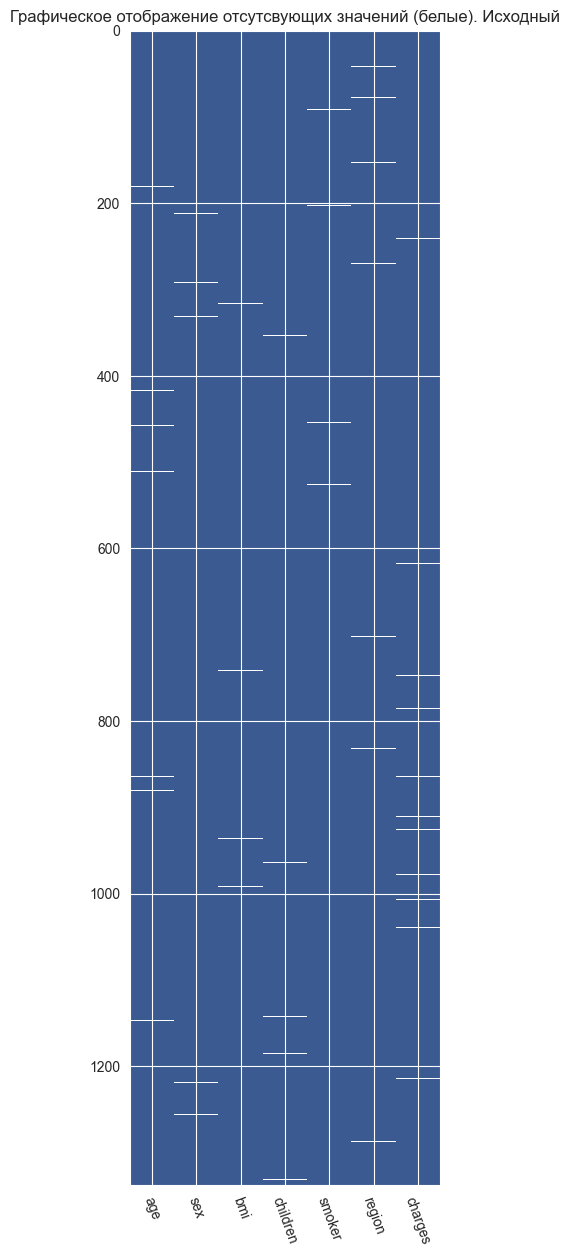

In [9]:
from matplotlib.colors import ListedColormap
def plotTableNA(dataF, addToTilte =""):
    '''  Функция для построения графика отображение отсутсвующих значений'''
    if   len(dataF.columns)> 20:   K = 3
    elif len(dataF.columns)== 1:   K = 1
    else:                          K = 1.7

    figSizeH = 15        # размер полотна, высота
    figSizeW =int(len(dataF.columns)/K) # размер полотна, ширина
    fig, ax = plt.subplots( figsize=(figSizeW, figSizeH))

    # отрисовать матрицу значений функцией imshow. Применяется цветовая палитра
    plt.imshow( dataF.isna(),
                cmap = ListedColormap([ '#3B5A92', 'white', ]), #cm.get_cmap('jet'),
                aspect='auto',  # ‘auto’ | ‘equal’ | scalar]
                interpolation= 'none',)
    ax.set_xticks(np.arange(len(dataF.columns)))
    ax.set_xticklabels(dataF.columns, rotation=-70,)
    plt.title("Графическое отображение отсутсвующих значений (белые). "+ addToTilte)

# Вызов функции с указанием параметров
plotTableNA( df, "Исходный")

Перед дальнейшими действиями следует обработать пропущенные значения. Варианты обработки:
- Вар.1. заполнить "особыми" значениями, которые невозможно встретить в выборке (прим.: "#NA")
- Вар.2. заполнить вычисленными значениями, рассчитанными на основе имеющихся значений признака (средние, мин., макс., и т.д.)
- Вар.3. исключить строки или столбцы:
  - Вар.3.1. исключить строки, в которых присутствуют пропущенные значения
  - Вар.3.2. исключить столбцы, в которых присутствуют пропущенные значения

In [10]:
print("Размер исходного DataFrame", df.shape)
print("Вар.3.1. Размер при исключении по строкам", df.dropna(axis='index', how='any').shape)
print("Вар.3.2. Размер при исключении по столбцам", df.dropna(axis='columns', how='any').shape)

Размер исходного DataFrame (1338, 7)
Вар.3.1. Размер при исключении по строкам (1289, 7)
Вар.3.2. Размер при исключении по столбцам (1338, 0)


In [11]:
# axis='index' - удаление строк
# axis='columns' - удаление столбцов
df = df.dropna(axis='index', how='any')
print("Размер таблицы после исключения пропусков", df.shape)

Размер таблицы после исключения пропусков (1289, 7)


In [12]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Результат замены категориальных или ранговых данных на числовые

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1289 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1289 non-null   float64
 1   sex       1289 non-null   object 
 2   bmi       1289 non-null   float64
 3   children  1289 non-null   float64
 4   smoker    1289 non-null   object 
 5   region    1289 non-null   object 
 6   charges   1289 non-null   float64
dtypes: float64(4), object(3)
memory usage: 80.6+ KB


Описание для не числовых значений

In [14]:
df.describe(include=['object', 'bool'])

,sex,smoker,region
count,1289,1289,1289
unique,2,2,4
top,male,no,southeast
freq,649,1025,352


In [15]:
objColNames = ['sex', 'smoker', 'region'] # названия признаков в исходной таблицы
prefixColNames =  ['sex', 'smoker', 'region']   # сокращенные названия признаков для новой таблицы

df_dummies = pd.get_dummies(
    df[objColNames],       # названия признаков в исходной
    prefix=prefixColNames,  # сокращенные названия в новой,
    dtype = int,
)
print(df_dummies[:3])

   sex_female  sex_male  smoker_no  smoker_yes  region_northeast  \
0           1         0          0           1                 0   
1           0         1          1           0                 0   
2           0         1          1           0                 0   

   region_northwest  region_southeast  region_southwest  
0                 0                 0                 1  
1                 0                 1                 0  
2                 0                 1                 0  


### Формирование таблицы с строго числовыми значениями

In [16]:
# список названий числовых признаков исходной таблицы
digitColName = [
    'age'       ,
    'bmi'    ,
    'children'    ,
    'charges']


# объединить выбранные столбцы из исходной таблицы df  с  столбцами созданной таблицы df_dummies
df_digPlus  = pd.concat(
                        [
                          df[digitColName],
                          df_dummies
                        ], # список объединяемых объектов

                        axis='columns' # способ объединения - по столбцам
)
df_digPlus.tail()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
1333,50.0,30.97,3.0,10600.5483,0,1,1,0,0,1,0,0
1334,18.0,31.92,0.0,2205.9808,1,0,1,0,1,0,0,0
1335,18.0,36.85,0.0,1629.8335,1,0,1,0,0,0,1,0
1336,21.0,25.80,0.0,2007.9450,1,0,1,0,0,0,0,1
1337,61.0,29.07,0.0,29141.3603,1,0,0,1,0,1,0,0


### Выбор целевого значения и признаков для анализа данных

In [17]:
df[digitColName].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1289 entries, 0 to 1337
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1289 non-null   float64
 1   bmi       1289 non-null   float64
 2   children  1289 non-null   float64
 3   charges   1289 non-null   float64
dtypes: float64(4)
memory usage: 50.4 KB


* __Коэффициент корреляции r-Пирсона__
  
  Мера линейной взаимосвязи переменных, при нелинейной взаимосвязи непоказателен. Не устойчив к выбросам в выборке. Учитывает числовые значения. Переменные должны иметь нормальное распределение. Изменяется в пределах от -1 до +1.

![Drag Racing](https://upload.wikimedia.org/wikipedia/commons/thumb/0/02/Correlation_examples.png/400px-Correlation_examples.png)

In [18]:
corr_df = df_digPlus.corr(method="pearson")
corr_df["charges"]

age                 0.304564
bmi                 0.201039
children            0.067020
charges             1.000000
sex_female         -0.056730
sex_male            0.056730
smoker_no          -0.790357
smoker_yes          0.790357
region_northeast    0.001289
region_northwest   -0.038368
region_southeast    0.072479
region_southwest   -0.038318
Name: charges, dtype: float64

Теперь нужно визуально оценить величину коэффициентов корреляции. Для этого построим тепловую карту по значениям взаимозависимости признаков выборки

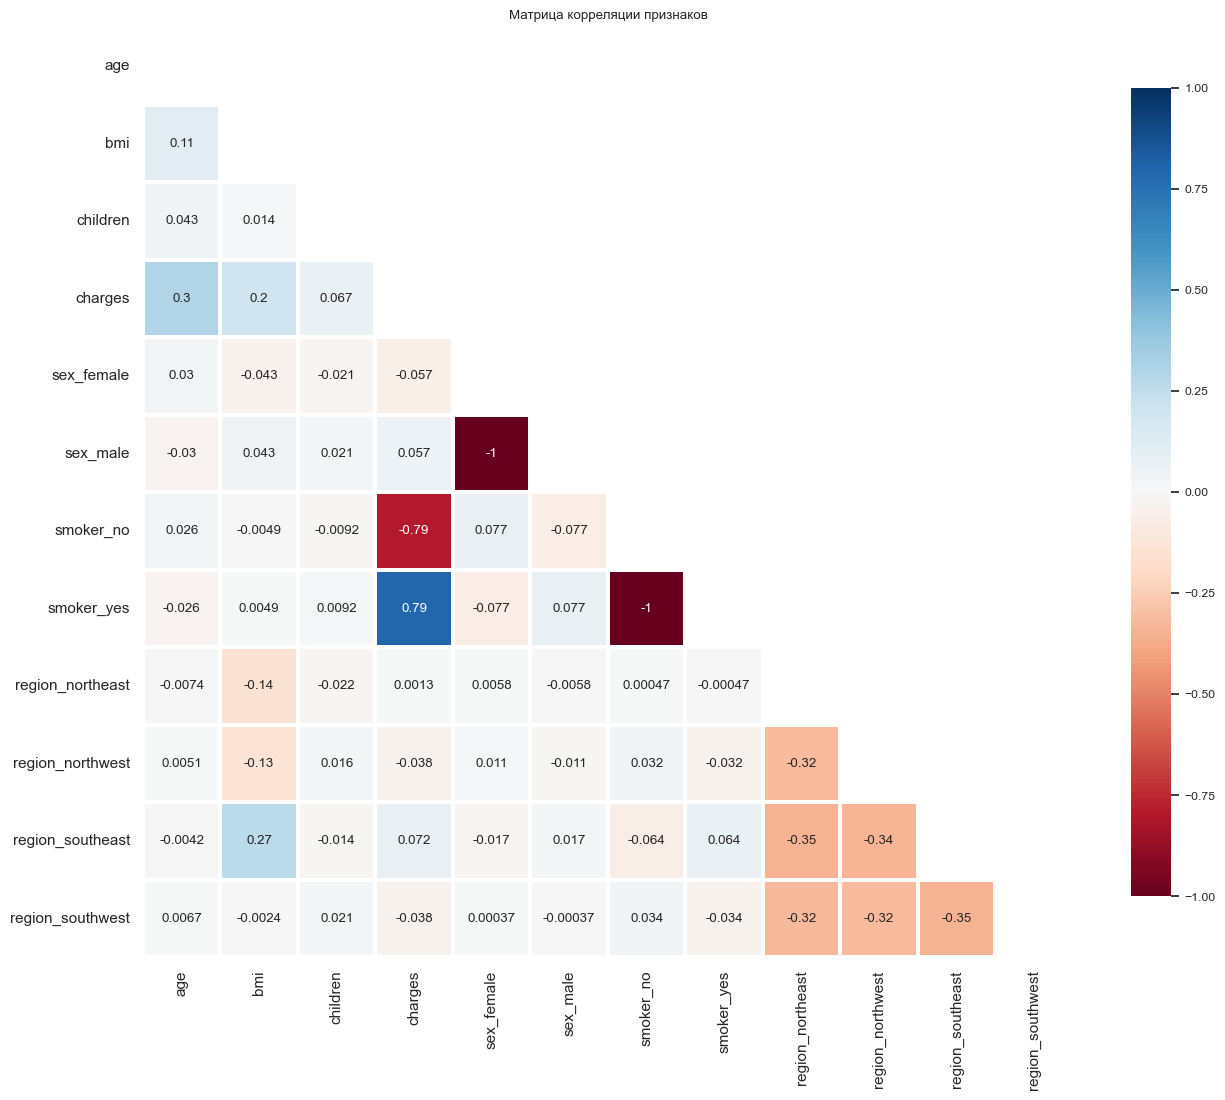

In [19]:
import matplotlib.pyplot as plt
sns.set(style="white")# цвет фона

# построить "маску" для отображения только половины корреляционной матрицы
mask = np.zeros_like(corr_df, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(15,15))
sns.set(font_scale=0.8) # размер шрифта

# Построить тепловую карту
sns.heatmap(
            ##################
            data=corr_df,   ### <<<- объект-матрица корреляции
            ##################
            vmin=-1, vmax=1, center=0,
            annot=True,
            cmap = 'RdBu',
            mask=mask,   # применить маску
            square=True, # форма ячейки - квадрат
            linewidths=1.5, # зазор между ячейки
            cbar_kws={"shrink": .7}  # уменьшить размер легенды
           )
plt.title(u'Матрица корреляции признаков');


In [20]:
# Последовательное применение операции:
# - получить единственный столбец,
# - получить абсолютные значения,
# - отсортировать
corr_df[['charges']].abs().sort_values(by="charges")

,charges
region_northeast,0.001289
region_southwest,0.038318
region_northwest,0.038368
sex_female,0.056730
sex_male,0.056730
children,0.067020
region_southeast,0.072479
bmi,0.201039
age,0.304564
smoker_no,0.790357


В качестве целевой переменной выберем признак:
- **'charges'** - индивидуальные медицинские расходы, оплачиваемые медицинской страховкой.


В качестве независимых переменных выберем признаки с высоким абс. значением коэфф. корреляции, но при этом как можно более не связанные между собой. Кандидаты:
  * **'age'** - возраст основного получателя
  * **'sex_male'** - страховой агент мужчина  
  * **'bmi'** - индекс массы тела 
  * **'children'** - кол-во детей охваченных медицинской страховкой / кол-во иждивенцев
  * **'smoker_no'** - страховой агент не курит
  * **'region_southwest'** - получатель проживает на юго-западе
  
  

In [21]:
features = ['age', 'sex_male', 'bmi', 'children', 'smoker_no', 'region_southwest']
target = ['charges']

In [22]:
df_digPlus= df_digPlus[features+target]
df_digPlus

,age,sex_male,bmi,children,smoker_no,region_southwest,charges
0,19.0,0,27.900,0.0,0,1,16884.92400
1,18.0,1,33.770,1.0,1,0,1725.55230
2,28.0,1,33.000,3.0,1,0,4449.46200
3,33.0,1,22.705,0.0,1,0,21984.47061
4,32.0,1,28.880,0.0,1,0,3866.85520
...,...,...,...,...,...,...,...
1333,50.0,1,30.970,3.0,1,0,10600.54830
1334,18.0,0,31.920,0.0,1,0,2205.98080
1335,18.0,0,36.850,0.0,1,0,1629.83350
1336,21.0,0,25.800,0.0,1,1,2007.94500


<Figure size 700x700 with 0 Axes>

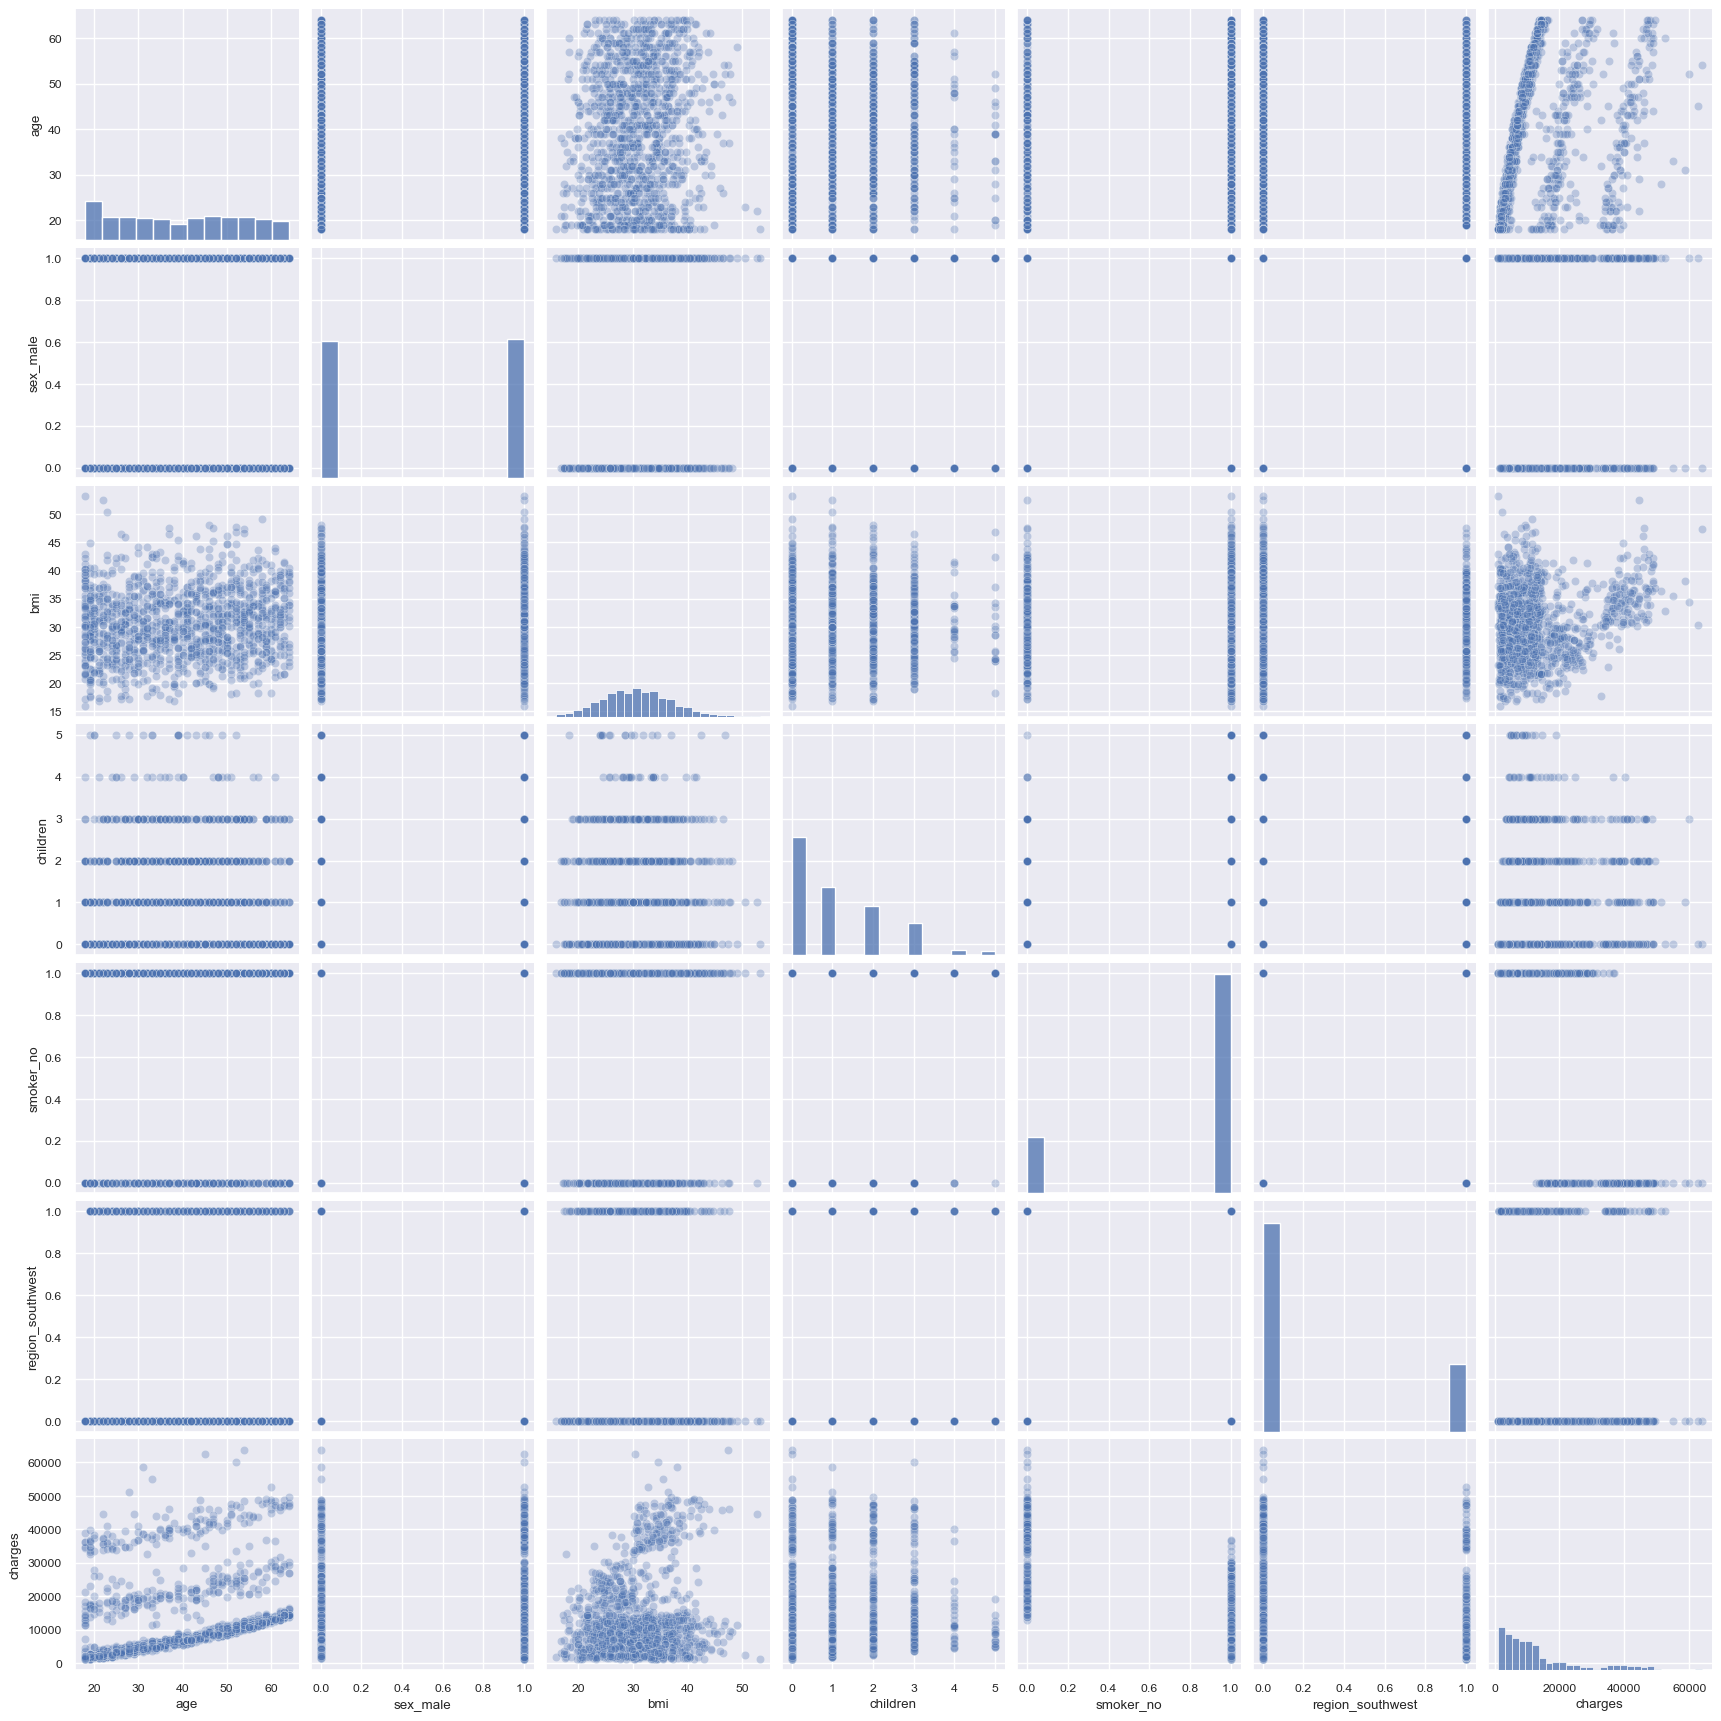

In [23]:
# График признаков попарно
plt.figure(figsize=(7,7))
%config InlineBackend.figure_format = 'png' # формат изображений PNG, для сокращения времени отрисовки графиков

sns.pairplot(
    df_digPlus[features + target],
    #hue = 'Type',         # Признак разделения
    kind="scatter",        # Тип даграмм: reg,scatter
    diag_kind = 'hist',     # Тип диагоральных даграмм: hist, kde
    plot_kws={'alpha':0.3} # прозрачность точек
);

### Поиск и обработка выбросов

Судя по виду графиков рассеяния в "пустых областях" присутствуют малое кол-во объектов, т.е. в выборе присутствуют аномально малые или большие значения - "выбросы". Для их обработки проведем следующие операции.

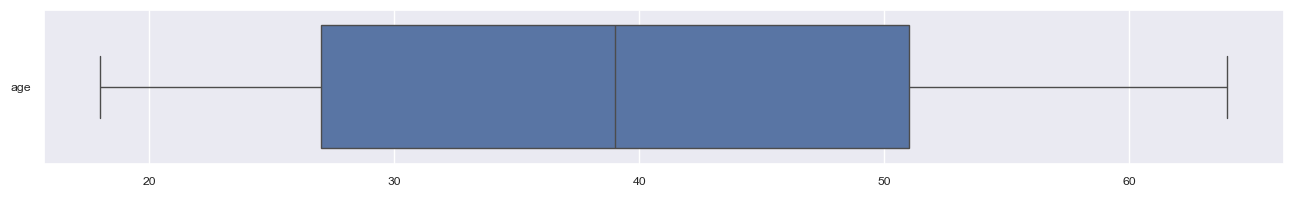

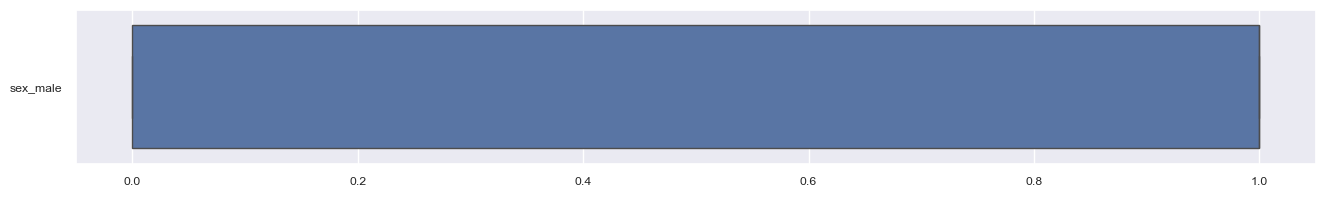

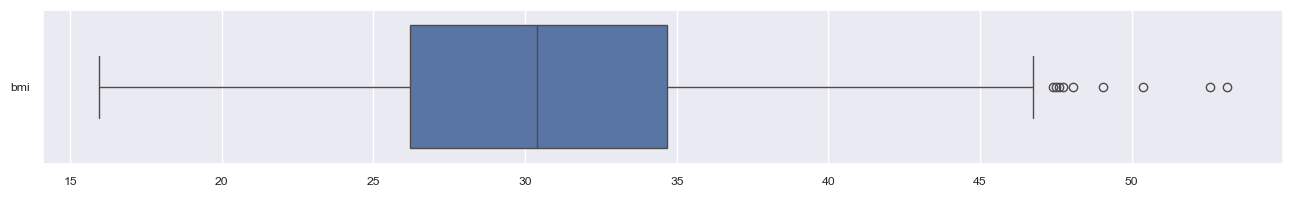

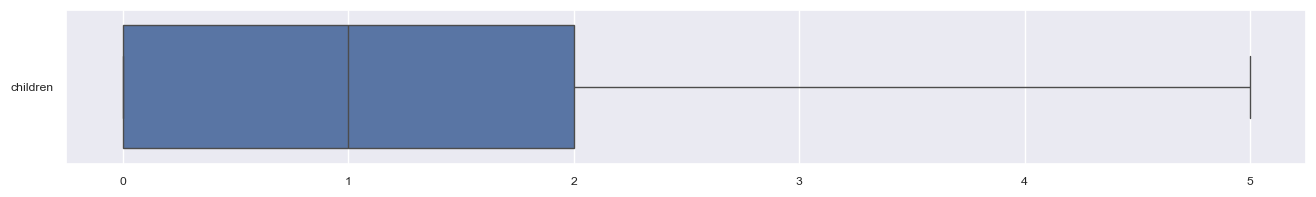

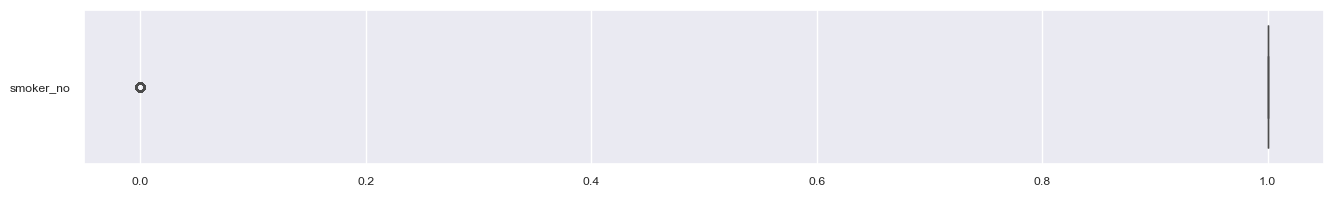

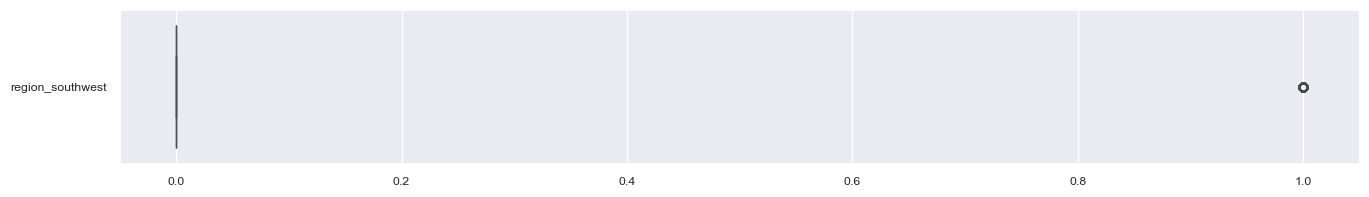

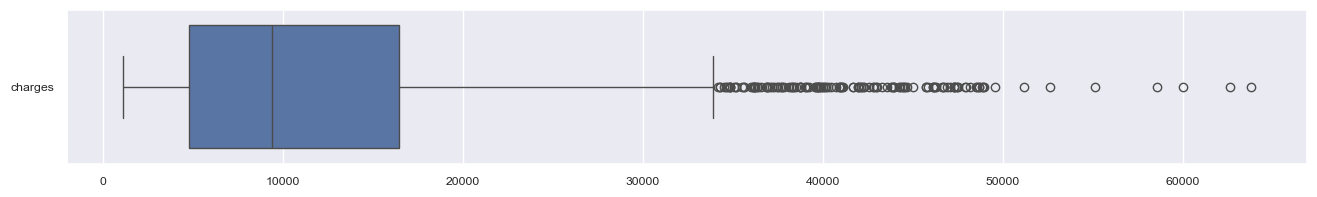

In [24]:
# Цикл: для каждого элемента в объединенном списке
for feature_name in (features+target):

    # Построить полотно для рисования с указанным размером
    plt.figure(figsize=(16,2))

    # На созданном полотне отрисовать boxplot
    sns.boxplot( data=df_digPlus[[feature_name]], # данные
                 orient='h' # ориентация графика
               )

In [25]:
# создадим "словарь"/"хэш-таблицу" для удобного обращения, где ключ - это название признака
# print (df_digPlus.sort_values('charges').tail())

tressholdDict = {
    'age'     : (26, 51)   ,
    'sex_male' : (0.0, 1.0),
    'bmi' : (26, 34.7)     , 
    'children'  : (0, 2)  ,
    'smoker_no' : (1.0, 1.0),
    'region_southwest' : (0.0, 0.0),
    'charges' : (50, 16500)
}

print (tressholdDict)

{'age': (26, 51), 'sex_male': (0.0, 1.0), 'bmi': (26, 34.7), 'children': (0, 2), 'smoker_no': (1.0, 1.0), 'region_southwest': (0.0, 0.0), 'charges': (50, 16500)}


Установим границы значений, для тех объектов таблицы, которые должны остаться

In [26]:
# Цикл: для каждого элемента в словаре/хэш-таблице пройтись по ключам - названиям признаков
for feature_name  in tressholdDict:
    threesMin =  tressholdDict[feature_name][0] # извлечь нижнее пороговое
    tresshMax =  tressholdDict[feature_name][1] # извлечь верхнее пороговое

    # Получить кол-во эл. вне пороговых значений. Прием - фильтрация
    over_count = len(  df_digPlus[
                            ~((df_digPlus[feature_name] >= threesMin ) & (df_digPlus[feature_name] <= tresshMax)) # фильтр по двум границам. ~ инверсия логических значений
                          ]
                    )

    dcount = df_digPlus[feature_name].count() # кол-во эл. общее

    print ('''{}. Принимаем пороговые значение равными {}.
  Кол-во эл. вне пороговых - {} из {} значение(ий) ({:.1%})\n'''.format(
        feature_name,
        tressholdDict[feature_name],
        over_count,
        dcount,
        over_count/ dcount,
    ))

age. Принимаем пороговые значение равными (26, 51).
  Кол-во эл. вне пороговых - 607 из 1289 значение(ий) (47.1%)

sex_male. Принимаем пороговые значение равными (0.0, 1.0).
  Кол-во эл. вне пороговых - 0 из 1289 значение(ий) (0.0%)

bmi. Принимаем пороговые значение равными (26, 34.7).
  Кол-во эл. вне пороговых - 626 из 1289 значение(ий) (48.6%)

children. Принимаем пороговые значение равными (0, 2).
  Кол-во эл. вне пороговых - 193 из 1289 значение(ий) (15.0%)

smoker_no. Принимаем пороговые значение равными (1.0, 1.0).
  Кол-во эл. вне пороговых - 264 из 1289 значение(ий) (20.5%)

region_southwest. Принимаем пороговые значение равными (0.0, 0.0).
  Кол-во эл. вне пороговых - 316 из 1289 значение(ий) (24.5%)

charges. Принимаем пороговые значение равными (50, 16500).
  Кол-во эл. вне пороговых - 321 из 1289 значение(ий) (24.9%)


In [27]:
df_digPlus.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1289 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1289 non-null   float64
 1   sex_male          1289 non-null   int64  
 2   bmi               1289 non-null   float64
 3   children          1289 non-null   float64
 4   smoker_no         1289 non-null   int64  
 5   region_southwest  1289 non-null   int64  
 6   charges           1289 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 80.6 KB


In [28]:
# Во избежание путаницы создадим для полседующих операций копию исходного объетка
df_digPlusFiltred = df_digPlus.copy()

for feature_name  in tressholdDict:
    threesMin =  tressholdDict[feature_name][0]
    tresshMax =  tressholdDict[feature_name][1]


    # фильтр по двум границам. Оператор "~" -инверсия логических значений
    df_digPlusFiltred = df_digPlusFiltred[
        (df_digPlusFiltred[feature_name] >= threesMin ) & (df_digPlusFiltred[feature_name] <= tresshMax)
        ]
    print("Обработан ", feature_name )


print ("Отброшено {} строк. Осталось {} строк.".format(
    len(df_digPlus)  - len(df_digPlusFiltred),
    len(df_digPlusFiltred))
)

Обработан  age
Обработан  sex_male
Обработан  bmi
Обработан  children
Обработан  smoker_no
Обработан  region_southwest
Обработан  charges
Отброшено 1126 строк. Осталось 163 строк.


In [29]:
df_digPlusFiltred

,age,sex_male,bmi,children,smoker_no,region_southwest,charges
4,32.0,1,28.880,0.0,1,0,3866.85520
6,46.0,0,33.440,1.0,1,0,8240.58960
8,37.0,1,29.830,2.0,1,0,6406.41070
24,37.0,1,28.025,2.0,1,0,6203.90175
43,37.0,0,30.800,2.0,1,0,6313.75900
...,...,...,...,...,...,...,...
1310,42.0,1,26.315,1.0,1,0,6940.90985
1311,33.0,0,26.695,0.0,1,0,4571.41305
1319,39.0,0,26.315,2.0,1,0,7201.70085
1326,42.0,0,32.870,0.0,1,0,7050.02130


age 26.0 51.0
sex_male 0 1
bmi 26.03 34.675
children 0.0 2.0
smoker_no 1 1
region_southwest 0 0
charges 2497.0383 10493.9458


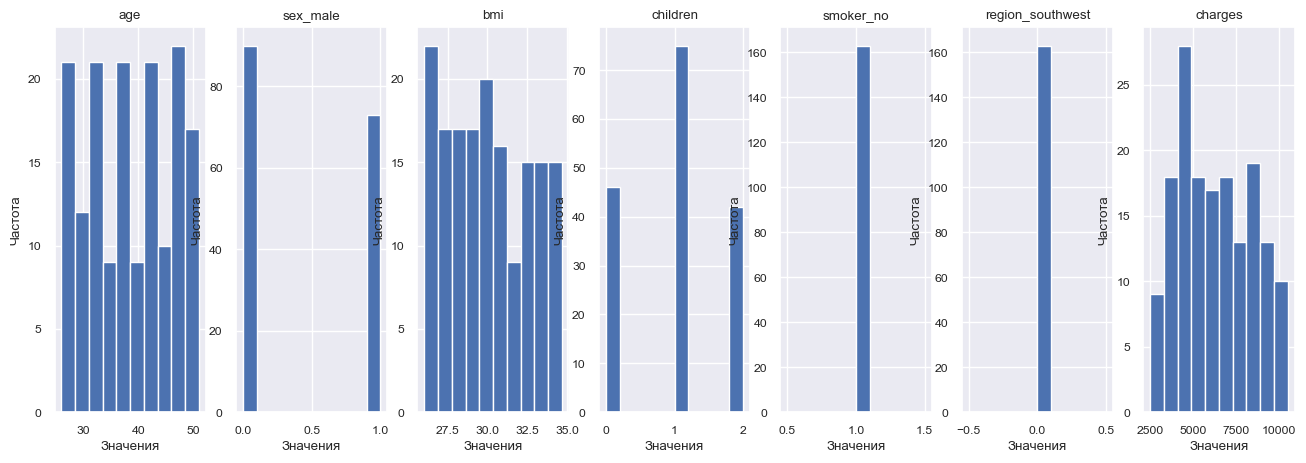

In [30]:
# Строим гистограммы по каждому признаку:
# data[features].hist() #Упрощенный вывод графиков

plt.figure(figsize=(16, 5))
plot_number = 0

for feature_name in (features+target):
    print (feature_name,
           df_digPlusFiltred[feature_name].min(),
           df_digPlusFiltred[feature_name].max())
    
    plot_number += 1

    plt.subplot(1, len(features+target), plot_number)

    plt.hist(df_digPlusFiltred[[feature_name]]) # Построение гистрограммы

    plt.title(feature_name)
    plt.xlabel(u'Значения')
    plt.ylabel(u'Частота')


In [31]:
df_digPlusFiltred.isna().sum()

age                 0
sex_male            0
bmi                 0
children            0
smoker_no           0
region_southwest    0
charges             0
dtype: int64

In [32]:
df_digPlusFiltred.to_csv('insu_nan_new.csv', index=False)

### Формирование тренировочной и проверочной выборок

In [33]:
valid_size = 0.3 # доля тестовой части в выборке
rand_seed = 8 # начальное состояние генератора случ. чисел

x_train, x_test, y_train, y_test =  train_test_split(
    df_digPlusFiltred[features],    # исходные данные X
    df_digPlusFiltred[target],      # исходные данные y

    test_size = valid_size, # доля тестовой части в выборке
    random_state=rand_seed, # начальное состояние генератора случ. чисел
    shuffle=True            # перемешивание
)

In [34]:
print ("Кол-во элементов: \n  x_train: {}, y_train {} \n  x_test:  {}, y_test  {} \n  total x: {}, total y {} ".format  (
    len(x_train), len(y_train),
    len(x_test),  len(x_test),
    len(x_train)+len(x_test), len(y_train)+len(x_test),
))

Кол-во элементов: 
  x_train: 114, y_train 114 
  x_test:  49, y_test  49 
  total x: 163, total y 163 


In [35]:
x_test[:3]

,age,sex_male,bmi,children,smoker_no,region_southwest
1243,28.0,0,33.110,0.0,1,0
597,34.0,0,33.250,1.0,1,0
1298,33.0,1,27.455,2.0,1,0


In [36]:
y_test[:3]

,charges
1243,3171.61490
597,5594.84550
1298,5261.46945


### Построение модели

#### Одномерная модель от признака age

In [37]:
lr = linear_model.LinearRegression()

Полученная модель требует процедуры обучения - подбора значений коэфф. для минимизации отличий между вычисленными значениями и предоставленными целевыми (обучающими y). У большинства моделей доступен метод __.fit( x_train,y_train)__

In [38]:
lin_model_age = lr.fit(
    x_train[['age']],
    y_train[['charges']]
)

y_pred_ChargesAge = lin_model_age.predict(x_test[['age']])

Построим теперь график рассеяния

Text(0.5, 1.0, 'График разброса')

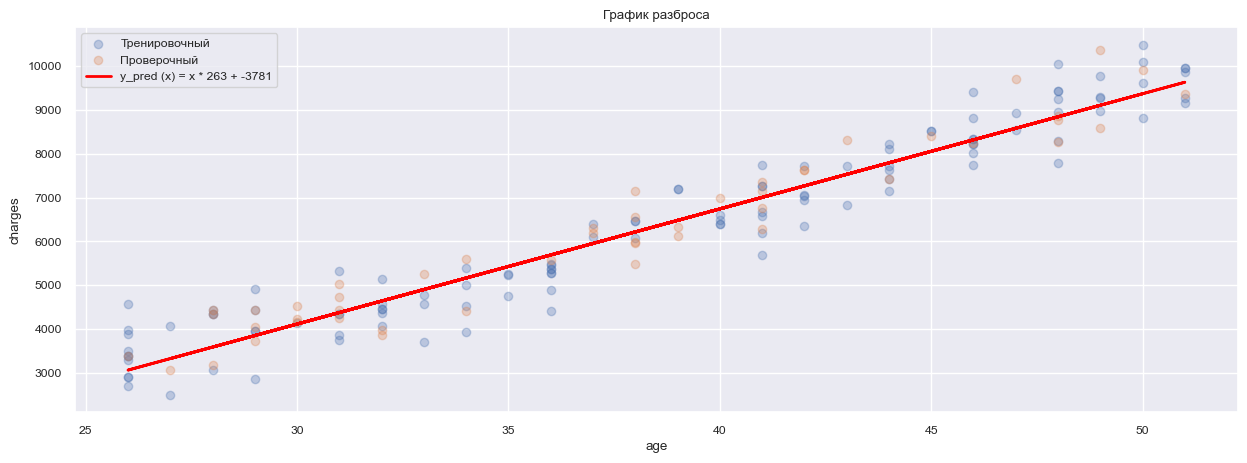

In [39]:
plt.figure(figsize=(15,5))

plt.scatter(x_train[['age']], y_train[['charges']], alpha=0.3, label='Тренировочный')
plt.scatter(x_test[['age']], y_test[['charges']], alpha=0.3, label='Проверочный')

label_str = "y_pred (x) = x * {:.0f} + {:.0f}".format(lin_model_age.coef_[0][0], lin_model_age.intercept_[0])

plt.plot(x_test[['age']], y_pred_ChargesAge, lw=2, color='red', label=label_str)

plt.legend(loc="best")
plt.xlabel('age')
plt.ylabel(target[0])
plt.title(u'График разброса')

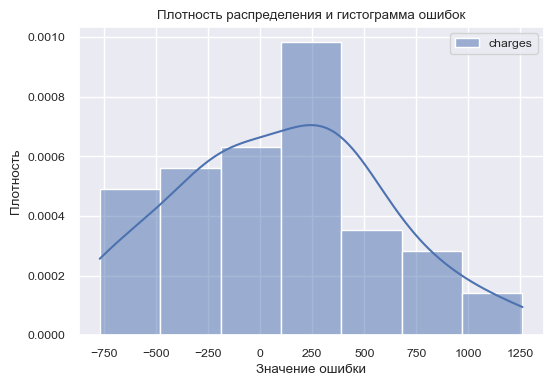

In [40]:
plt.figure(figsize=(6,4))

# Гистограмма и Плотность распределения - sns.distplot
# data = y_true - y_pred
#sns.distplot(y_test[['Price']]- y_pred_PriceYearBuilt)
sns.histplot(y_test[['charges']]- y_pred_ChargesAge,
             color="red",
             kde=True, # оценка плотности в виде кривой
             stat="density",# density: общая площадь равна 1
            )

# Осевая линия
plt.plot(
    [0, 0],
    [0, 10 * pow(10,-7)], '--', lw=2, c='r')

plt.ylabel(u'Плотность')
plt.xlabel(u'Значение ошибки')
plt.title(u'Плотность распределения и гистограмма ошибок');
plt.show()

Text(0, 0.5, 'Абсолютная ошибка')

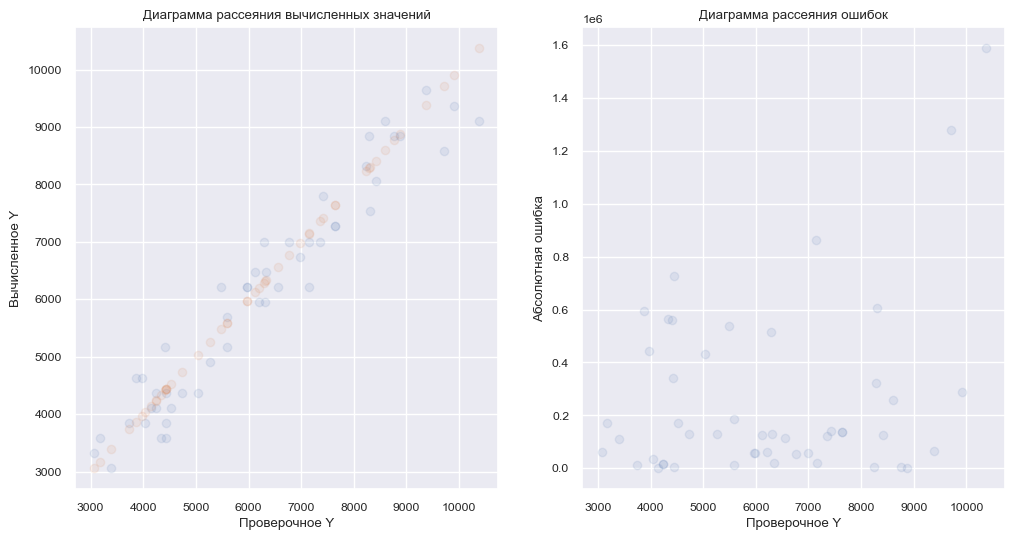

In [41]:
plt.figure(figsize=(12,6))

# создать первое полотно 121: 1-строк, 2-столбцов, 1-индекс в сетке
plt.subplot(121)
plt.scatter(y_test[['charges']], y_pred_ChargesAge,  alpha=0.1)
plt.scatter(y_test[['charges']], y_test[['charges']],  alpha=0.1)
plt.title('Диаграмма рассеяния вычисленных значений');
plt.xlabel('Проверочное Y')
plt.ylabel('Вычисленное Y')

# создать первое полотно 122: 1-строк, 2-столбцов, 2-индекс в сетке
plt.subplot(122)
plt.scatter(y_test[['charges']], (y_test[['charges']] - y_pred_ChargesAge)**2,  alpha=0.1)

plt.title('Диаграмма рассеяния ошибок')
plt.xlabel('Проверочное Y')
plt.ylabel('Абсолютная ошибка')


#### Полученные результаты

In [42]:
print ("Линейная одномерная регрессия. Признак 'charges'.")
def summary(x,y):
    print (f"R2 - коэфф. детерминации:{metrics.r2_score(y_test[['charges']], y)}")
    print (f"MAE - средняя абсолютная ошибка: {metrics.mean_absolute_error(y_test[['charges']], y)}")
    print (f"RMSE - кв. корень из среднеквадратичной ошибки: {np.sqrt(metrics.mean_squared_error(y_test[['charges']], y))}")
summary(lin_model_age, y_pred_ChargesAge)

Линейная одномерная регрессия. Признак 'charges'.
R2 - коэфф. детерминации:0.9328636689609504
MAE - средняя абсолютная ошибка: 415.4347440131073
RMSE - кв. корень из среднеквадратичной ошибки: 503.72956317641996


#### Выводы по полученным результатам (одномерная модель от признака 'age')

#### Многомерная модель от признаков ('sex_male', 'bmi', 'region_southwest')

In [43]:
lr_sexMale_bmi_regionSouth = linear_model.LinearRegression()

linear_model_sexMale_bmi_regionSouth = lr_sexMale_bmi_regionSouth.fit(
    x_train[['region_southwest', 'sex_male', 'bmi']],
    y_train[['charges']]
)

y_pred_sexMale_bmi_regionSouth = linear_model_sexMale_bmi_regionSouth.predict(x_test[['region_southwest', 'sex_male', 'bmi']])

In [44]:
def showGraphic(x):
    plt.figure(figsize=(12,6))
    
    # создать первое полотно 121: 1-строк, 2-столбцов, 1-индекс в сетке
    plt.subplot(121)
    plt.scatter(y_test[['charges']], x,  alpha=0.1)
    plt.scatter(y_test[['charges']], y_test[['charges']],  alpha=0.1)
    plt.title('Диаграмма рассеяния вычисленных значений');
    plt.xlabel('Проверочное Y')
    plt.ylabel('Вычисленное Y')

    # создать первое полотно 121: 1-строк, 2-столбцов, 2-индекс в сетке
    plt.subplot(122)
    plt.scatter(y_test[['charges']], (y_test[['charges']] - x)**2,  alpha=0.1)

    plt.title('Диаграмма рассеяния ошибок')
    plt.xlabel('Проверочное Y')
    plt.ylabel('Абсолютная ошибка')

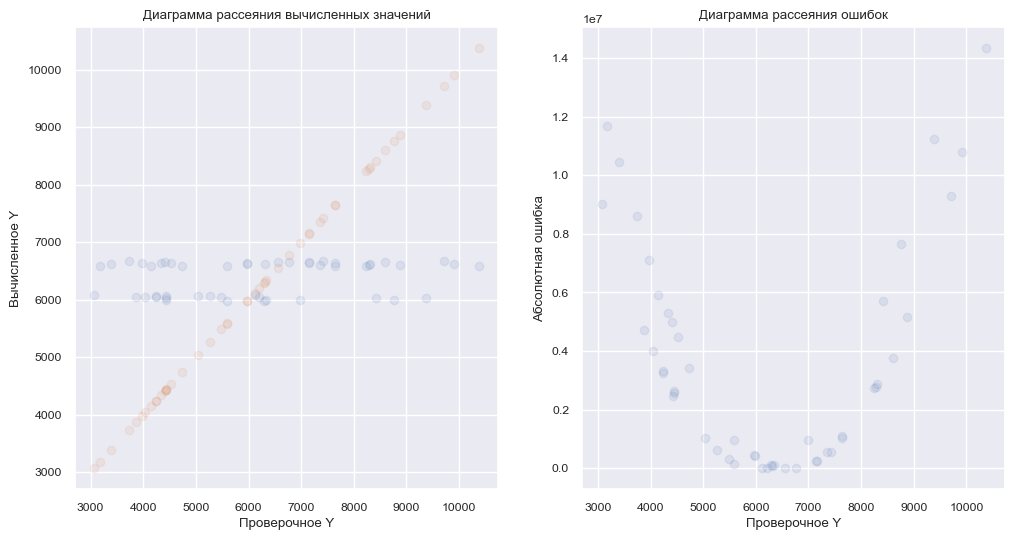

In [45]:
showGraphic(y_pred_sexMale_bmi_regionSouth)

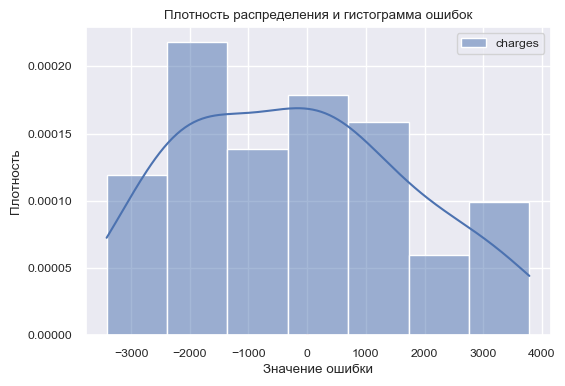

In [46]:
plt.figure(figsize=(6,4))

# Гистограмма и Плотность распределения - sns.distplot
# data = y_true - y_pred
#sns.distplot(y_test[['Price']]- y_pred_PriceYearBuilt)
sns.histplot(y_test[['charges']]- y_pred_sexMale_bmi_regionSouth,
             color="red",
             kde=True, # оценка плотности в виде кривой
             stat="density",# density: общая площадь равна 1
            )

# Осевая линия
plt.plot(
    [0, 0],
    [0, 10 * pow(10,-7)], '--', lw=2, c='r')

plt.ylabel(u'Плотность')
plt.xlabel(u'Значение ошибки')
plt.title(u'Плотность распределения и гистограмма ошибок');
plt.show()

#### Полученные результаты

In [56]:
print ("Линейная многомерная регрессия. Признаки sex_male, bmi, region_southwest. ")
summary(linear_model_sexMale_bmi_regionSouth, y_pred_sexMale_bmi_regionSouth)

Линейная многомерная регрессия. Признаки sex_male, bmi, region_southwest. 
R2 - коэфф. детерминации:0.031271250659467564
MAE - средняя абсолютная ошибка: 1605.2187159634973
RMSE - кв. корень из среднеквадратичной ошибки: 1913.4615170498575


#### Многомерная модель от признаков ('age', 'children', 'smoker_no')

In [57]:
lr_child_smokNo_age = linear_model.LinearRegression()

linear_model_child_smokNo_age = lr_child_smokNo_age.fit(
    x_train[['children', 'smoker_no', 'age']],
    y_train[['charges']]
)

y_pred_child_smokNo_age = linear_model_child_smokNo_age.predict(x_test[['children','smoker_no', 'age']])

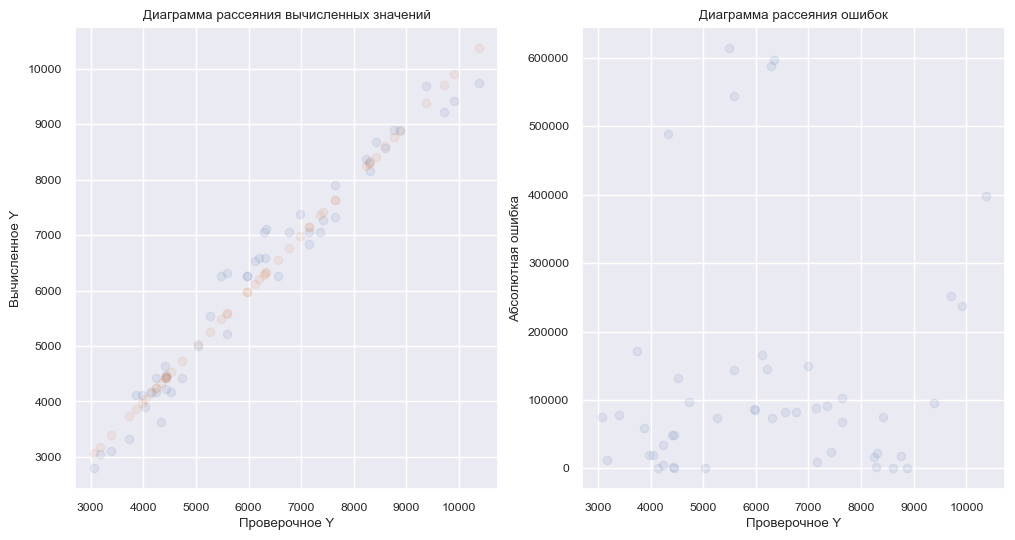

In [58]:
showGraphic(y_pred_child_smokNo_age)

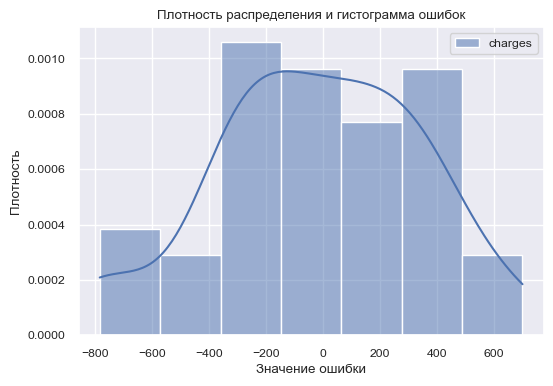

In [59]:
plt.figure(figsize=(6,4))

# Гистограмма и Плотность распределения - sns.distplot
# data = y_true - y_pred
#sns.distplot(y_test[['Price']]- y_pred_PriceYearBuilt)
sns.histplot(y_test[['charges']]- y_pred_child_smokNo_age,
             color="red",
             kde=True, # оценка плотности в виде кривой
             stat="density",# density: общая площадь равна 1
            )

# Осевая линия
plt.plot(
    [0, 0],
    [0, 10 * pow(10,-7)], '--', lw=2, c='r')

plt.ylabel(u'Плотность')
plt.xlabel(u'Значение ошибки')
plt.title(u'Плотность распределения и гистограмма ошибок');
plt.show()

In [60]:
print ("Линейная многомерная регрессия. Признаки age, children, smoker_no.")
summary(linear_model_child_smokNo_age, y_pred_child_smokNo_age)

Линейная многомерная регрессия. Признаки age, children, smoker_no.
R2 - коэфф. детерминации:0.9664069182625923
MAE - средняя абсолютная ошибка: 290.0805503411167
RMSE - кв. корень из среднеквадратичной ошибки: 356.32275802836995


In [61]:
linear_model_child_smokNo_age.coef_

array([[579.80698801,   0.        , 262.93996126]])

### Сравнение полученных моделей

In [52]:
results = pd.DataFrame(
    {
        "Признак": ["age", "sex_male, bmi, region_southwest", "age, children, smoker_no"],
        "K":       ['?',     0,     0], 
        "B":       ['?',     0,     0],
        "R2":      [0.933,     0.031,     0.966],
        "MAE":     [415,     1605,     290],
        "RMSE":    [504,      1915,     356],         
    }
)

In [53]:
results

,Признак,K,B,R2,MAE,RMSE
0,age,?,?,0.933,415,504
1,"sex_male, bmi, region_southwest",0,0,0.031,1605,1915
2,"age, children, smoker_no",0,0,0.966,290,356


## Выводы

В ходе данной лабораторной работы мы:
- Вычислили основные характеристики (max, min, avg)
- Подготовили данные для обучения
- Использовали линейную одномерную и многомерную регрессию.
- Построили графики плотности распределения и ошибок
В результате можно сделать общий вывод, что точность предсказаний модели в первую очередь зависит от кол-ва и качетсва зависимости между целевой переменной от независимых